In [1]:
import tensorflow as tf
from tensorflow import keras

import numpy as np

print(tf.__version__)

1.12.0


# Download the IMDB dataset

In [2]:
imdb = keras.datasets.imdb

(train_data, train_labels), (test_data, test_labels) = imdb.load_data(num_words=10000)

17465344/17464789 [==============================] - 1s 0us/step


The argument num_words=10000 keeps the top 10,000 most frequently occurring words in the training data. The rare words are discarded to keep the size of the data manageable.

## Explore the data

In [3]:
print("Training entries: {}, labels: {}".format(len(train_data), len(train_labels)))

Training entries: 25000, labels: 25000


In [4]:
print(train_data[0])

[1, 14, 22, 16, 43, 530, 973, 1622, 1385, 65, 458, 4468, 66, 3941, 4, 173, 36, 256, 5, 25, 100, 43, 838, 112, 50, 670, 2, 9, 35, 480, 284, 5, 150, 4, 172, 112, 167, 2, 336, 385, 39, 4, 172, 4536, 1111, 17, 546, 38, 13, 447, 4, 192, 50, 16, 6, 147, 2025, 19, 14, 22, 4, 1920, 4613, 469, 4, 22, 71, 87, 12, 16, 43, 530, 38, 76, 15, 13, 1247, 4, 22, 17, 515, 17, 12, 16, 626, 18, 2, 5, 62, 386, 12, 8, 316, 8, 106, 5, 4, 2223, 5244, 16, 480, 66, 3785, 33, 4, 130, 12, 16, 38, 619, 5, 25, 124, 51, 36, 135, 48, 25, 1415, 33, 6, 22, 12, 215, 28, 77, 52, 5, 14, 407, 16, 82, 2, 8, 4, 107, 117, 5952, 15, 256, 4, 2, 7, 3766, 5, 723, 36, 71, 43, 530, 476, 26, 400, 317, 46, 7, 4, 2, 1029, 13, 104, 88, 4, 381, 15, 297, 98, 32, 2071, 56, 26, 141, 6, 194, 7486, 18, 4, 226, 22, 21, 134, 476, 26, 480, 5, 144, 30, 5535, 18, 51, 36, 28, 224, 92, 25, 104, 4, 226, 65, 16, 38, 1334, 88, 12, 16, 283, 5, 16, 4472, 113, 103, 32, 15, 16, 5345, 19, 178, 32]


In [5]:
len(train_data[0]), len(train_data[1])

(218, 189)

## Convert the integers back to words

In [6]:
# A dictionary mapping words to an integer index
word_index = imdb.get_word_index()

# The first indices are reserved
word_index = {k:(v+3) for k,v in word_index.items()} 
word_index["<PAD>"] = 0
word_index["<START>"] = 1
word_index["<UNK>"] = 2  # unknown
word_index["<UNUSED>"] = 3

reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])

def decode_review(text):
    return ' '.join([reverse_word_index.get(i, '?') for i in text])

1646592/1641221 [==============================] - 0s 0us/step


In [7]:
decode_review(train_data[0])

"<START> this film was just brilliant casting location scenery story direction everyone's really suited the part they played and you could just imagine being there robert <UNK> is an amazing actor and now the same being director <UNK> father came from the same scottish island as myself so i loved the fact there was a real connection with this film the witty remarks throughout the film were great it was just brilliant so much that i bought the film as soon as it was released for <UNK> and would recommend it to everyone to watch and the fly fishing was amazing really cried at the end it was so sad and you know what they say if you cry at a film it must have been good and this definitely was also <UNK> to the two little boy's that played the <UNK> of norman and paul they were just brilliant children are often left out of the <UNK> list i think because the stars that play them all grown up are such a big profile for the whole film but these children are amazing and should be praised for wh

## Prepare the data

views—the arrays of integers—must be converted to tensors before fed into the neural network. This conversion can be done a couple of ways:

Convert the arrays into vectors of 0s and 1s indicating word occurrence, similar to a one-hot encoding. For example, the sequence [3, 5] would become a 10,000-dimensional vector that is all zeros except for indices 3 and 5, which are ones. Then, make this the first layer in our network—a Dense layer—that can handle floating point vector data. This approach is memory intensive, though, requiring a num_words * num_reviews size matrix.

Alternatively, we can pad the arrays so they all have the same length, then create an integer tensor of shape max_length * num_reviews. We can use an embedding layer capable of handling this shape as the first layer in our network.

In this tutorial, we will use the second approach.

Since the movie reviews must be the same length, we will use the pad_sequences function to standardize the lengths:

In [8]:
train_data = keras.preprocessing.sequence.pad_sequences(train_data,
                                                        value=word_index["<PAD>"],
                                                        padding='post',
                                                        maxlen=256)

test_data = keras.preprocessing.sequence.pad_sequences(test_data,
                                                       value=word_index["<PAD>"],
                                                       padding='post',
                                                       maxlen=256)

In [9]:
len(train_data[0]), len(train_data[1])

(256, 256)

In [10]:
print(train_data[0])

[   1   14   22   16   43  530  973 1622 1385   65  458 4468   66 3941
    4  173   36  256    5   25  100   43  838  112   50  670    2    9
   35  480  284    5  150    4  172  112  167    2  336  385   39    4
  172 4536 1111   17  546   38   13  447    4  192   50   16    6  147
 2025   19   14   22    4 1920 4613  469    4   22   71   87   12   16
   43  530   38   76   15   13 1247    4   22   17  515   17   12   16
  626   18    2    5   62  386   12    8  316    8  106    5    4 2223
 5244   16  480   66 3785   33    4  130   12   16   38  619    5   25
  124   51   36  135   48   25 1415   33    6   22   12  215   28   77
   52    5   14  407   16   82    2    8    4  107  117 5952   15  256
    4    2    7 3766    5  723   36   71   43  530  476   26  400  317
   46    7    4    2 1029   13  104   88    4  381   15  297   98   32
 2071   56   26  141    6  194 7486   18    4  226   22   21  134  476
   26  480    5  144   30 5535   18   51   36   28  224   92   25  104
    4 

## Build the model

The neural network is created by stacking layers—this requires two main architectural decisions:

How many layers to use in the model?
How many hidden units to use for each layer?
In this example, the input data consists of an array of word-indices. The labels to predict are either 0 or 1. Let's build a model for this problem:

In [12]:
vocab_size = 10000

model = keras.Sequential()
model.add(keras.layers.Embedding(vocab_size, 16))
model.add(keras.layers.GlobalAveragePooling1D())
model.add(keras.layers.Dense(16, activation=tf.nn.relu))
model.add(keras.layers.Dense(1, activation=tf.nn.sigmoid))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 16)          160000    
_________________________________________________________________
global_average_pooling1d (Gl (None, 16)                0         
_________________________________________________________________
dense (Dense)                (None, 16)                272       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 17        
Total params: 160,289
Trainable params: 160,289
Non-trainable params: 0
_________________________________________________________________


In [13]:
model.compile(optimizer=tf.train.AdamOptimizer(),
              loss='binary_crossentropy',
              metrics=['accuracy'])

## Create a validation set

When training, we want to check the accuracy of the model on data it hasn't seen before. Create a validation set by setting apart 10,000 examples from the original training data. (Why not use the testing set now? Our goal is to develop and tune our model using only the training data, then use the test data just once to evaluate our accuracy).

In [14]:
x_val = train_data[:10000]
partial_x_train = train_data[10000:]

y_val = train_labels[:10000]
partial_y_train = train_labels[10000:]

## Train the model

In [15]:
history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=40,
                    batch_size=512,
                    validation_data=(x_val, y_val),
                    verbose=1)

Train on 15000 samples, validate on 10000 samples
Epoch 1/40
15000/15000 [==============================] - 1s 52us/step - loss: 0.6915 - acc: 0.6402 - val_loss: 0.6892 - val_acc: 0.7189
Epoch 2/40
15000/15000 [==============================] - 1s 40us/step - loss: 0.6851 - acc: 0.7443 - val_loss: 0.6809 - val_acc: 0.7288
Epoch 3/40
15000/15000 [==============================] - 1s 40us/step - loss: 0.6728 - acc: 0.7595 - val_loss: 0.6657 - val_acc: 0.7519
Epoch 4/40
15000/15000 [==============================] - 1s 40us/step - loss: 0.6514 - acc: 0.7627 - val_loss: 0.6416 - val_acc: 0.7688
Epoch 5/40
15000/15000 [==============================] - 1s 39us/step - loss: 0.6193 - acc: 0.7933 - val_loss: 0.6072 - val_acc: 0.7843
Epoch 6/40
15000/15000 [==============================] - 1s 39us/step - loss: 0.5773 - acc: 0.8084 - val_loss: 0.5651 - val_acc: 0.7949
Epoch 7/40
15000/15000 [==============================] - ETA: 0s - loss: 0.5299 - acc: 0.827 - 1s 40us/step - loss: 0.5289 - ac

## Evaluate the model

And let's see how the model performs. Two values will be returned. Loss (a number which represents our error, lower values are better), and accuracy.

In [16]:
results = model.evaluate(test_data, test_labels)

print(results)

25000/25000 [==============================] - 0s 12us/step
[0.328850633354187, 0.87296]


## Create a graph of accuracy and loss over time

model.fit() returns a History object that contains a dictionary with everything that happened during training:

In [17]:
history_dict = history.history
history_dict.keys()

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])

There are four entries: one for each monitored metric during training and validation. We can use these to plot the training and validation loss for comparison, as well as the training and validation accuracy:

In [18]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

# "bo" is for "blue dot"
plt.plot(epochs, loss, 'bo', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

<Figure size 640x480 with 1 Axes>

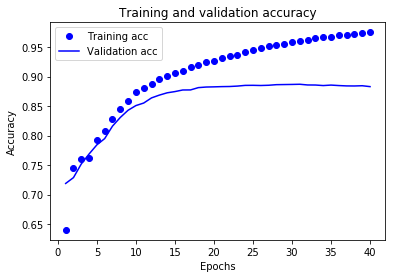

In [19]:
plt.clf()   # clear figure
acc_values = history_dict['acc']
val_acc_values = history_dict['val_acc']

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In this plot, the dots represent the training loss and accuracy, and the solid lines are the validation loss and accuracy.

Notice the training loss decreases with each epoch and the training accuracy increases with each epoch. This is expected when using a gradient descent optimization—it should minimize the desired quantity on every iteration.

This isn't the case for the validation loss and accuracy—they seem to peak after about twenty epochs. This is an example of overfitting: the model performs better on the training data than it does on data it has never seen before. After this point, the model over-optimizes and learns representations specific to the training data that do not generalize to test data.

For this particular case, we could prevent overfitting by simply stopping the training after twenty or so epochs. Later, you'll see how to do this automatically with a callback.